In [1]:
from functions import *

In [2]:
# Loading in the data
#df = pd.read_csv("1990BoxScoreData.csv")
#df.head()

In [2]:
df = get_games()
df.reset_index(drop = True, inplace=True)
df.head()

100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22023,1610612737,ATL,Atlanta Hawks,0022300431,2023-12-29,ATL vs. SAC,L,239,110,...,0.840,18,33,51.0,29,9,4,15,16,-7.0
1,22023,1610612737,ATL,Atlanta Hawks,0022300408,2023-12-26,ATL @ CHI,L,239,113,...,0.857,12,28,40.0,24,6,3,15,21,-5.0
2,22023,1610612737,ATL,Atlanta Hawks,0022300393,2023-12-23,ATL vs. MEM,L,239,119,...,0.800,13,28,41.0,28,8,5,10,22,-6.0
3,22023,1610612737,ATL,Atlanta Hawks,0022300384,2023-12-22,ATL @ MIA,L,240,113,...,0.714,12,31,43.0,29,9,2,13,23,-9.0
4,22023,1610612737,ATL,Atlanta Hawks,0022300371,2023-12-20,ATL @ HOU,W,240,134,...,0.821,12,32,44.0,31,4,3,9,18,7.0


In [3]:
# Creating a column to indicate if the home team is playing
df['Home'] = 1
# Creating a list of indices to include 
inds_to_include = []
# Iterating through the rows
for (index, row) in tqdm(df.iterrows()):
    # Getting rid of the first character on the SEASON_ID
    row.SEASON_ID = str(row.SEASON_ID)[1:]
    df.loc[index, 'SEASON_ID'] = row.SEASON_ID
    # Setting home games
    if '@' in row.MATCHUP:
        df.loc[index, 'Home'] = 0
    
    # Setting the WL column to be binary instead of W or L
    if row.WL == 'W':
        df.loc[index, 'WL'] = 1
    else:
        df.loc[index, 'WL'] = 0

    # Only including the in-season months
    month = int(row.GAME_DATE.split('-')[1])
    if month < 7 or month > 9:
        inds_to_include.append(index)

# Dropping necessary columns and resetting indices
df = df.loc[inds_to_include, :]
df.drop(columns = ['TEAM_NAME', 'MATCHUP'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

0it [00:00, ?it/s]

79970it [00:31, 2550.51it/s]


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home
0,2023,1610612737,ATL,0022300431,2023-12-29,0,239,110,37,94,...,18,33,51.0,29,9,4,15,16,-7.0,1
1,2023,1610612737,ATL,0022300408,2023-12-26,0,239,113,41,89,...,12,28,40.0,24,6,3,15,21,-5.0,0
2,2023,1610612737,ATL,0022300393,2023-12-23,0,239,119,45,96,...,13,28,41.0,28,8,5,10,22,-6.0,1
3,2023,1610612737,ATL,0022300384,2023-12-22,0,240,113,42,96,...,12,31,43.0,29,9,2,13,23,-9.0,0
4,2023,1610612737,ATL,0022300371,2023-12-20,1,240,134,47,91,...,12,32,44.0,31,4,3,9,18,7.0,0


In [4]:
quant_cols = ['MIN','PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']
def helper_func(group):
    # Sort in ascending order by date
    group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
    group.sort_values(by = 'GAME_DATE', ascending=True, inplace=True)
    # Replace any columns that have NA's with 0 
    group.fillna(0, inplace=True)
    # Create a running sum shifted by 1 of the quantitative columns 
    group[quant_cols] = group[quant_cols].expanding(1).sum().shift(1).copy()
    # Create a running count shifted by 1
    group['Count'] = group['GAME_DATE'].expanding(1).count().shift(1).copy()
    # Divide each quantitative column by the count to get a running average
    for col in quant_cols:
        group[col] = group[col] / group['Count']

    # Convert the WL column into a win percentage 
    group['WIN_PCT'] = group['WL'].expanding(1).sum().shift(1).copy() / group['Count']
    # Remove the Count column from the group 
    group.drop(columns='Count', inplace=True)
    # Return the group 
    return group

# Sort by unique SEASON_ID and TEAM_ID, apply the helper_func(), drop all the NA's and reset the indices
running_totals = df.groupby(['SEASON_ID', 'TEAM_ID']).apply(helper_func).dropna().reset_index(drop=True)
running_totals[running_totals['TEAM_ABBREVIATION'] == 'DET'].tail(50)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home,WIN_PCT
75084,2022,1610612765,DET,0022200992,2023-03-09,0,241.757143,110.857143,39.400000,87.271429,...,31.785714,42.757143,22.900000,7.071429,3.928571,14.714286,22.400000,-7.957143,1,0.214286
75085,2022,1610612765,DET,0022201006,2023-03-11,0,241.732394,110.746479,39.408451,87.295775,...,31.774648,42.830986,22.859155,7.042254,3.929577,14.774648,22.394366,-7.985915,1,0.211268
75086,2022,1610612765,DET,0022201020,2023-03-13,1,241.694444,110.805556,39.458333,87.388889,...,31.750000,42.819444,22.888889,7.041667,3.972222,14.736111,22.416667,-7.958333,1,0.208333
75087,2022,1610612765,DET,0022201028,2023-03-14,0,241.684932,110.890411,39.575342,87.561644,...,31.767123,42.945205,22.958904,7.082192,3.986301,14.726027,22.397260,-7.575342,0,0.219178
75088,2022,1610612765,DET,0022201042,2023-03-16,0,241.648649,110.702703,39.554054,87.716216,...,31.675676,42.959459,22.891892,7.094595,3.972973,14.675676,22.351351,-7.743243,1,0.216216
75089,2022,1610612765,DET,0022201066,2023-03-19,0,241.613333,110.560000,39.546667,87.680000,...,31.573333,42.880000,22.906667,7.106667,3.960000,14.706667,22.320000,-7.893333,1,0.213333
75090,2022,1610612765,DET,0022201078,2023-03-21,0,241.605263,110.421053,39.526316,87.605263,...,31.552632,42.828947,22.947368,7.065789,3.934211,14.657895,22.289474,-7.947368,0,0.210526
75091,2022,1610612765,DET,0022201099,2023-03-24,0,241.571429,110.376623,39.493506,87.649351,...,31.480519,42.727273,22.909091,7.077922,3.909091,14.584416,22.337662,-8.129870,0,0.207792
75092,2022,1610612765,DET,0022201122,2023-03-27,0,241.538462,110.205128,39.423077,87.461538,...,31.474359,42.679487,22.910256,7.089744,3.910256,14.679487,22.282051,-8.294872,1,0.205128
75093,2022,1610612765,DET,0022201142,2023-03-29,0,241.531646,110.291139,39.443038,87.518987,...,31.493671,42.734177,22.898734,7.063291,3.860759,14.620253,22.253165,-8.303797,0,0.202532


In [10]:
# Create a dataframe for the matchups
match_df = pd.DataFrame()

for (index, row) in tqdm(running_totals.iterrows()):
    # Get the current team's id 
    team_id = row.TEAM_ID
    # Find the opponent's stats
    other_team = running_totals[(running_totals['GAME_ID'] == row.GAME_ID) & (running_totals['TEAM_ID'] != row.TEAM_ID)].copy()
    # Drop the unnecessary/redundant columns
    other_team.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'Home'], inplace=True)
    # Reset the index
    other_team.reset_index(inplace=True, drop=True)
    # Create new columns with suffix _y for the other team
    new_cols = [col + "_y" for col in list(other_team.columns)]
    # Save new columns as the other team's columns
    other_team.columns = new_cols
    # Combine this team and other team data
    this_row = pd.DataFrame([row]).reset_index(drop=True)
    this_row = pd.concat((this_row, other_team), axis=1)
    #for col in list(other_team.columns):
        #this_row[col] = other_team[col]
    # Concatenate the new dataframe with this one 
    match_df = pd.concat((match_df, this_row))

76232it [12:05, 105.06it/s]


In [18]:
X = match_df.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE']).dropna().reset_index(drop=True).apply(pd.to_numeric)
Y = X['WL'].copy()
X.drop(columns=['WL'], inplace=True)

from sklearn.model_selection import train_test_split

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 421)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=2/len(X), random_state = 420)

In [19]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, RidgeClassifierCV, RidgeClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#model = KNeighborsClassifier(n_neighbors=150)
#model = OneClassSVM(kernel='rbf')
model = LogisticRegressionCV()
model.fit(X_train, Y_train)

print("Train Accuracy: %.3f %%" % (100 * accuracy_score(Y_train, model.predict(X_train))))
print("Test  Accuracy: %.3f %%" % (100 * accuracy_score(Y_test, model.predict(X_test))))
print(confusion_matrix(Y_test, model.predict(X_test)))
print("Test ROC Score: %.4f" % (roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))) if len(Y_test) > 50 else print("")

Train Accuracy: 66.033 %
Test  Accuracy: 50.000 %
[[1 0]
 [1 0]]



Text(0, 0.5, 'Actual Probability Won')

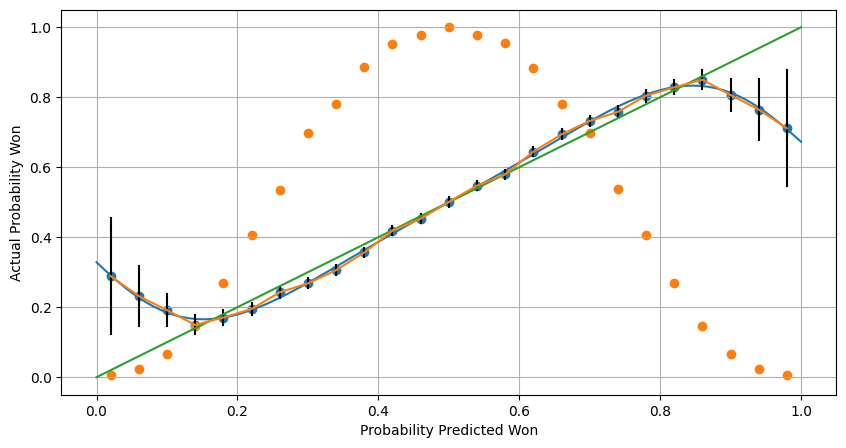

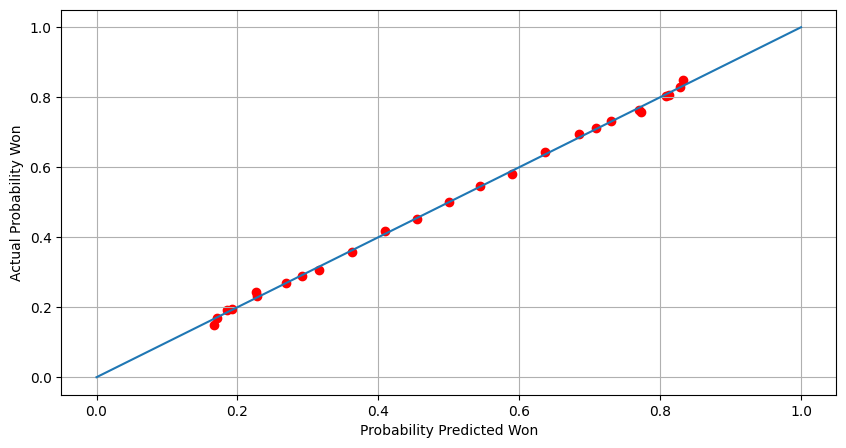

In [43]:
from sklearn.linear_model import LinearRegression
(bounds, probs, samples, errors) = prob_plot(Y_train, model.predict_proba(X_train)[:,1], bins=25)

x_bounds = 0.5*(bounds[1:]+bounds[0:-1]).copy()
y_probs = probs.copy()

poly = PolynomialFeatures(7)
x_bounds_poly = poly.fit_transform(x_bounds.reshape(-1,1))

linear_model = LinearRegression()
linear_model.fit(x_bounds_poly, y_probs)

def conversion_func(x, linear_model, poly):
    x = poly.transform(x.reshape(-1,1))
    return linear_model.predict(x)

x_test = np.linspace(0,1,100)
x_test_poly = poly.transform(x_test.reshape(-1,1))
y_test = linear_model.predict(x_test_poly)

plt.figure(figsize=(10,5))
plt.scatter(x_bounds, y_probs)
plt.plot(x_test, y_test)
plt.scatter(0.5*(bounds[1:]+bounds[0:-1]), samples / np.max(samples))
plt.errorbar(0.5*(bounds[1:]+bounds[0:-1]), probs, yerr=errors, ecolor='black')
plt.plot([0,1], [0,1])
plt.grid()
plt.xlabel("Probability Predicted Won")
plt.ylabel("Actual Probability Won")

plt.figure(figsize=(10,5))
plt.scatter(conversion_func(x_bounds, linear_model, poly), y_probs, c='red')
plt.plot([0,1], [0,1])
plt.grid()
plt.xlabel("Probability Predicted Won")
plt.ylabel("Actual Probability Won")

In [20]:
quant_cols = ['MIN','PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']
def helper_func_test(group):
    # Sort in ascending order by date
    group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
    group.sort_values(by = 'GAME_DATE', ascending=True, inplace=True)
    # Replace any columns that have NA's with 0 
    group.fillna(0, inplace=True)
    # Create a running sum shifted by 1 of the quantitative columns 
    group[quant_cols] = group[quant_cols].expanding(1).sum().copy()
    # Create a running count shifted by 1
    group['Count'] = group['GAME_DATE'].expanding(1).count().copy()
    # Divide each quantitative column by the count to get a running average
    for col in quant_cols:
        group[col] = group[col] / group['Count']

    # Convert the WL column into a win percentage 
    group['WIN_PCT'] = group['WL'].expanding(1).sum().shift(1).copy() / group['Count']
    # Remove the Count column from the group 
    group.drop(columns='Count', inplace=True)
    # Return the group 
    return group

# Sort by unique SEASON_ID and TEAM_ID, apply the helper_func(), drop all the NA's and reset the indices
test_df = df.groupby(['SEASON_ID', 'TEAM_ID']).apply(helper_func).dropna().reset_index(drop=True)
test_df = test_df[test_df['SEASON_ID'] == '2023'].copy()
test_df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home,WIN_PCT
75186,2023,1610612737,ATL,0012300028,2023-10-12,1,238.000000,108.00,37.000000,85.00,...,40.000000,50.000000,22.000000,9.000000,2.000000,20.000000,16.0,1.000000,1,1.00
75187,2023,1610612737,ATL,0012300035,2023-10-14,1,239.000000,105.50,38.500000,88.00,...,37.000000,45.500000,25.500000,12.500000,3.500000,20.000000,18.5,1.000000,1,1.00
75188,2023,1610612737,ATL,0012300044,2023-10-16,0,239.666667,107.00,39.666667,88.00,...,36.666667,45.666667,26.333333,13.333333,3.333333,20.666667,18.0,2.333333,0,1.00
75189,2023,1610612737,ATL,0012300068,2023-10-20,0,239.250000,108.25,39.750000,86.75,...,36.250000,45.500000,24.750000,11.250000,3.250000,19.750000,18.0,0.750000,0,0.75
75190,2023,1610612737,ATL,0022300063,2023-10-25,0,239.400000,107.80,39.200000,86.00,...,35.000000,45.200000,25.800000,11.200000,3.200000,20.600000,18.6,-2.200000,0,0.60


In [37]:
home_team = 'DET'
away_team = 'TOR'
team1 = test_df[test_df['TEAM_ABBREVIATION'] == home_team].tail(1).copy() # Home Team
team2 = test_df[test_df['TEAM_ABBREVIATION'] == away_team].tail(1).copy()

for col in team1.columns:
    if '_y' in col:
        team1.drop(columns = [col], inplace=True)
        team2.drop(columns = [col], inplace=True)

# Set team1 as the home team 
team1["Home"] = 1
pd.concat((team1, team2)).head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home,WIN_PCT
76198,2023,1610612765,DET,0022300421,2023-12-28,0,240.852941,110.411765,41.205882,88.500000,...,32.911765,44.205882,25.705882,6.294118,5.323529,16.000000,23.352941,-10.441176,1,0.117647
76059,2023,1610612761,TOR,0022300432,2023-12-29,0,241.676471,114.058824,42.764706,89.647059,...,33.558824,46.000000,29.676471,8.000000,5.029412,14.264706,18.617647,1.617647,0,0.470588


In [38]:
final_df = pd.DataFrame()
# Get the current team's id 
team_id = team1['TEAM_ID']
# Drop the unnecessary/redundant columns
team2.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'Home'], inplace=True)
# Reset the index
team1.reset_index(inplace=True, drop=True)
team2.reset_index(inplace=True, drop=True)
# Create new columns with suffix _y for the other team
new_cols = [col + "_y" for col in list(team2.columns)]
# Save new columns as the other team's columns
team2.columns = new_cols
# Combine this team and other team data
for col in list(team2.columns):
    team1[col] = team2[col]
# Concatenate the new dataframe with this one 
final_df = pd.concat((final_df, team1))

X_test_final = final_df.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL']).dropna().reset_index(drop=True).apply(pd.to_numeric)
X_test_final = scaler.transform(X_test_final)

print("Probability that %s wins: %.2f%%" % (home_team, 100 * conversion_func(model.predict_proba(X_test_final)[0][1], linear_model, poly)))
print("Probability that %s wins: %.2f%%" % (away_team, 100 * conversion_func(model.predict_proba(X_test_final)[0][0], linear_model, poly)))

Probability that DET wins: 27.87%
Probability that TOR wins: 72.18%


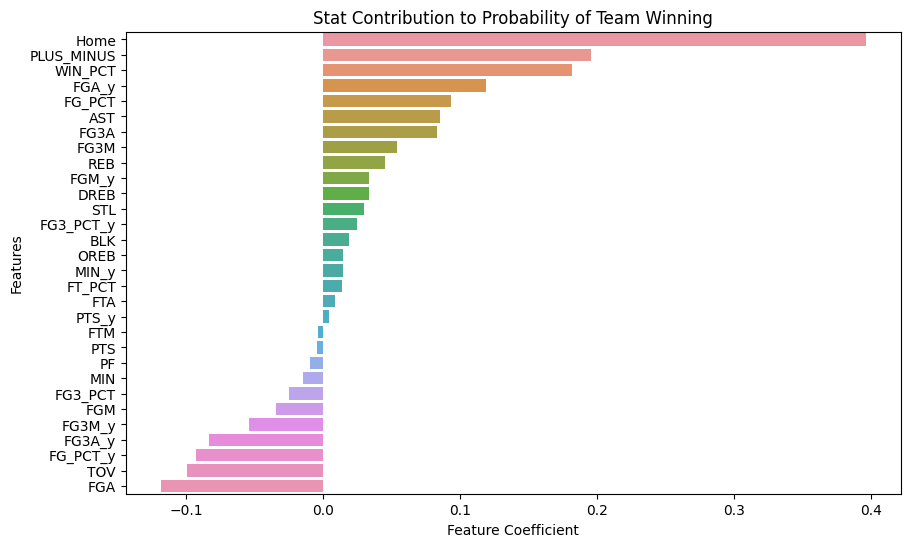

In [53]:
import seaborn as sns

importance_scores = model.coef_[0]

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores}).head(30)

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Coefficient')
plt.ylabel('Features')
plt.title('Stat Contribution to Probability of Team Winning')
plt.show()